# Here you need to add the paper title, and then a small block of general explanation for a binder

# Notebook to generate dummy data to be used in the included notebooks

Import libraries

In [14]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib widget

# The cell below will need to be changed for a generalized binder

In [15]:
sys.path.insert(0, '../ReSurfEMG')
from TMSiSDK.file_readers import Poly5Reader
import helper_functions as hf

# Reruns should be done from this cell as the start

Now you can pick a file from the list, which have been numbered.

In [65]:
t_start = 0     # s
t_end = 7*60    # s
emg_sample_rate = 2048   # Hz
draeger_sample_rate = 100   # Hz 

# Ventilator settings:
peep = 10       # Positive end-expiratory pressure (cmH2O)
dp = 5          # Driving pressure (cmH2O)
rr = 22         # Respiratory rate /min
ie_ratio = 1/2  # Ratio between inspiratory and expiratory phase
ie_fraction = ie_ratio/(ie_ratio + 1)

# Patient variables
p_mus_max = 5   # Muscular pressure (cmH2O)
c = .050        # Respiratory system compliance (L/cmH2O)
r = 5           # Respiratory system resistance (cmH2O/L/s)
p_ip = -5       # Static interpleural pressure (cmH2O)

tau_mus_up = 0.3
tau_mus_down = 0.3

# To simulate occlussion measurements
# t_occs = np.array([])
t_occs = np.array([5*60+5, 5*60+21, 5*60+35])
t_occs = np.floor(t_occs*rr/60)*60/rr
for i, t_occ in enumerate(t_occs):
    if t_end < (t_occ + 60/rr):
        print('t=' +  str(t_occ) + ': t_occ should be more than a respiratory cycle from t_end\n')

t_occs

array([302.72727273, 319.09090909, 332.72727273])

In [73]:
# Ventilator data generator

# data_draeger_samples = data_draeger.samples[:data_draeger.num_samples]
# x_draeger = data_draeger_samples
y_draeger = np.array([i/draeger_sample_rate for i in range(int(t_start*draeger_sample_rate), int(t_end*draeger_sample_rate))])

# p_mus = 5*np.sin(y_draeger*rr/60*2*np.pi)
# p_mus[p_mus > 0] = 0
p_mus_block = (signal.square(y_draeger*rr/60*2*np.pi + 0.1, ie_fraction)+1)/2
for i, t_occ in enumerate(t_occs):
     n_occ = int(t_occ*draeger_sample_rate)
     p_mus_block[n_occ:n_occ+int(draeger_sample_rate*60/rr)] = -5*(signal.square(np.arange(int(draeger_sample_rate*60/rr))*rr/60*2*np.pi, ie_fraction)+1)/2

pattern_gen_mus = np.zeros((len(y_draeger),))
for i in range(1, len(y_draeger)):
    if (p_mus_block[i-1]-pattern_gen_mus[i-1]) > 0:
        pattern_gen_mus[i] = pattern_gen_mus[i-1]+(p_mus_block[i-1]-pattern_gen_mus[i-1])/(tau_mus_up*draeger_sample_rate)
    else:
        pattern_gen_mus[i] = pattern_gen_mus[i-1]+(p_mus_block[i-1]-pattern_gen_mus[i-1])/(tau_mus_down*draeger_sample_rate)

p_mus = p_mus_max * pattern_gen_mus

p_block = dp * (signal.square(y_draeger*rr/60*2*np.pi, ie_fraction)+1)/2
# p_block = dp * (signal.square(y_draeger*rr/60*2*np.pi, 0.4)+1)/2
tau_dp_up = 10
tau_dp_down = 5
p_dp = -p_mus
for i in range(1, len(y_draeger)):
    if np.any((((t_occs*draeger_sample_rate)-i)<=0) &  ((((t_occs+rr/60)*draeger_sample_rate)-i)>0)):
        p_dp[i] = -p_dp[i]
    elif (p_block[i-1]-p_dp[i-1]) > 0:
        p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_up
    else:
        p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_down

p_vent = peep + p_dp

v_dot_vent = np.zeros((len(y_draeger),))
v_vent = np.zeros((len(y_draeger),))
for i in range(len(y_draeger)-1):
    if np.any((((t_occs*draeger_sample_rate)-i)<=0) &  ((((t_occs+rr/60)*draeger_sample_rate)-i)>0)):
        v_dot_vent[i+1] = 0
        v_vent[i+1] = 0
    else:
        v_dot_vent[i+1] = ((p_dp[i] + p_mus[i]) - v_vent[i] / c)/r
        v_vent[i+1] = v_vent[i] + v_dot_vent[i+1] * 1/draeger_sample_rate
    # if (p_block[i-1]-p_dp[i-1]) > 0:
    #     p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_up
    # else:
    #     p_dp[i] = p_dp[i-1]+(p_block[i-1]-p_dp[i-1])/tau_dp_down


x_draeger = np.vstack((p_vent, v_dot_vent, v_vent))
data_draeger_samples = x_draeger



In [74]:
# EMG generator

# data_emg_samples = data_emg.samples[:data_emg.num_samples]
# x_emg = data_emg_samples
y_emg = np.array([i/emg_sample_rate for i in range(int(t_start*emg_sample_rate), int(t_end*emg_sample_rate))])

# pattern_gen_emg = np.sin(y_emg*rr/60*2*np.pi)
# pattern_gen_emg[pattern_gen_emg < 0] = 0

emg_block = (signal.square(y_emg*rr/60*2*np.pi + 0.5, ie_fraction)+1)/2
for i, t_occ in enumerate(t_occs):
     n_occ = int(t_occ*emg_sample_rate)
     emg_block[n_occ:n_occ+int(emg_sample_rate*60/rr)] = (signal.square(np.arange(int(emg_sample_rate*60/rr))*rr/60*2*np.pi, ie_fraction)+1)/2


pattern_gen_emg = np.zeros((len(y_emg),))
for i in range(1, len(y_emg)):
    if (emg_block[i-1]-pattern_gen_emg[i-1]) > 0:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_up*emg_sample_rate)
    else:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_down*emg_sample_rate)


x_emg = np.zeros((3,len(y_emg)))
part_ecg = np.zeros((len(y_emg),))
rng = np.random.default_rng(seed=42)
part_emg = pattern_gen_emg * np.random.normal(0, 0.5, size=(len(y_emg), ))
part_noise = np.random.normal(0, 0.5, size=(len(y_emg), ))
part_drift = np.zeros((len(y_emg),))
b, a  = scipy.signal.butter(4, 0.1, btype='low', analog=False, output='ba', fs=emg_sample_rate)
# part_drift = scipy.signal.filtfilt(b, a, np.random.normal(0, 0.5, size=(len(y_emg), )))

x_emg[0, :] = part_ecg + 0.05 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[1, :] = part_ecg + 4 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[2, :] = part_ecg + 8 * part_emg + 1 * part_noise + 20 * part_drift


data_emg_samples = x_emg


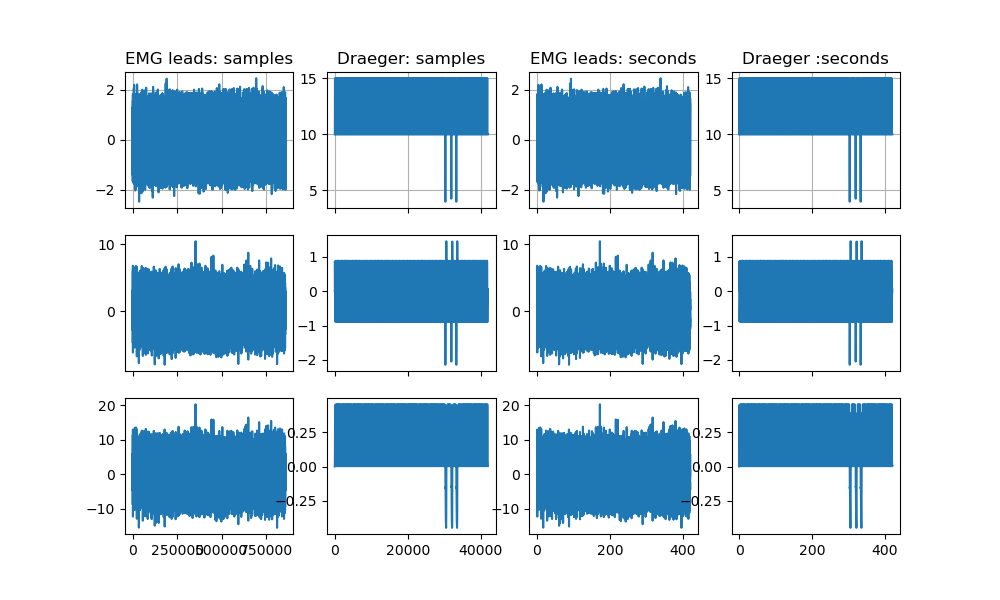

In [75]:
fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(10, 6), sharex='col')
axis[0, 0].grid(True)
axis[0, 0].plot(x_emg[0])
axis[0, 0].set(title='EMG leads: samples')
axis[1, 0].plot(x_emg[1])
axis[2, 0].plot(x_emg[2])

axis[0, 1].set(title='Draeger: samples')
axis[0, 1].grid(True)
axis[0, 1].plot(x_draeger[0])
axis[1, 1].plot(x_draeger[1])
axis[2, 1].plot(x_draeger[2])

axis[0, 2].grid(True)
axis[0, 2].plot(y_emg, x_emg[0])
axis[0, 2].set(title='EMG leads: seconds')
axis[1, 2].plot(y_emg, x_emg[1])
axis[2, 2].plot(y_emg, x_emg[2])

axis[0, 3].set(title='Draeger :seconds')
axis[0, 3].grid(True)
axis[0, 3].plot(y_draeger, x_draeger[0])
axis[1, 3].plot(y_draeger, x_draeger[1])
axis[2, 3].plot(y_draeger, x_draeger[2])

Here pick the part of the signal you want to look at. It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [61]:
start_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-100),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(y_draeger[-1]-10),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

In [ ]:
start = start_widget.value
end = end_widget.value
if start >= end:
    print('Please choose logical values. You made a mistake.')

In [ ]:
# now examine at the selected window to contain all occlusions
time_view = 'Seconds'
if time_view == 'Seconds':
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(x_emg[0,:])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate)
    end_draeger_s = min([int(float(end)* draeger_sample_rate), len(x_draeger[0,:])-1])

else:
    start_s = int(float(start))
    end_s = min([int(float(end)), len(data_emg_samples[0])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate/emg_sample_rate)
    end_draeger_s = min([int(float(start)* draeger_sample_rate/emg_sample_rate), len(data_draeger_samples[0])-1])
    y_emg = [range(len(data_emg_samples[0]))]
    y_draeger = [range(len(data_draeger_samples[0]))]


fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
axis[0, 0].set(title='leads in EMG')
axis[0, 0].grid(True)
axis[0, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[0][int(start_s):int(end_s)])
axis[1, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[1][int(start_s):int(end_s)])
axis[2, 0].plot(y_emg[int(start_s):int(end_s)], x_emg[2][int(start_s):int(end_s)])

axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)
axis[1, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[1][int(start_draeger_s):int(end_draeger_s)]
)
axis[2, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[2][int(start_draeger_s):int(end_draeger_s)]
)

Happy with your selection? If not redo

# Pre-processing pipeline

In [ ]:
# Eliminate the baseline wander from the data
bd_filtered_file_data = hf.emg_bandpass_butter_sample(data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

In [ ]:
# Apply QRS gating
# Gating settings
plot_window = 5         # Window size to plot the gating results from
peak_fraction = 0.50    # Peak height fraction
ECG_shift = -0           # Shift of gated in samples relative to detected peaks
gate_width = 0.1        # Gate width in seconds

# Detect ECG peaks on 1Hz high-pass filtered signals
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)

ecg = bd_filtered_file_data[0]
ecg_rms = hf.full_rolling_rms(ecg, 10)
max_ecg_rms = max(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = hf.emg_bandpass_butter_sample(processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
gate_fill_method = 3    # 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(int(ECG_peaks[i]-gate_width_samples/2),int(ECG_peaks[i]+gate_width_samples/2)):
        gate_samples.append(k)

ECG_gated = hf.gating(ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = hf.gating(emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = hf.gating(emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)

# Plot output data --------------------------------

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(y_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[2].grid(True)
axis[2].plot(y_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[3].grid(True)
axis[3].plot(y_emg[start_i:end_i], emg_para_gated[start_i:end_i])

axis[4].grid(True)
axis[4].plot(y_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[4].hlines(
    y=peak_height, 
    xmin=y_emg[start_i], 
    xmax=y_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if (ECG_peaks[idx] > int(start_s)) & (ECG_peaks[idx] < int(start_s+plot_window*2048)):
        axis[4].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


# Calculate root mean squared (RMS)

In [ ]:
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)
RMS_data_emg_para = hf.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_di[int(start_s):int(end_s)])
axis[0].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_di[int(start_s):int(end_s)])

axis[2].set(title='leads in EMG')
axis[2].set_ylabel('sEMGpara (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[int(start_s):int(end_s)], processed_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[3].set_xlabel('t (s)')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].plot(y_emg[int(start_s):int(end_s)], RMS_data_emg_para[int(start_s):int(end_s)])

axis[4].set_ylabel('P_vent (cmH2O)')
axis[4].grid(True)
axis[4].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)



Determine PEEP level

In [ ]:
x = x_draeger[2][:int(start_draeger_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-x)

PEEP_set = np.floor(np.median(x_draeger[0, V_ee_PKS]))


PEEP_set

In [ ]:
# Moving baseline on pressure and all EMG signals for baseline crossing detection

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_draeger = 5 * draeger_sample_rate  # window length

# emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
emg_para_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

for idx in range(int(end_s)-int(start_s)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    emg_di_rolling_base_line[idx] = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    emg_para_rolling_base_line[idx] = np.percentile(
        RMS_data_emg_para[start_i:end_i], 33)

for idx in range(int(end_draeger_s)-int(start_draeger_s)):
    start_i = max([int(start_draeger_s), int(
        start_draeger_s)+idx-int(baseline_W_draeger/2)])
    end_i = min([int(end_draeger_s), int(start_draeger_s) +
                idx+int(baseline_W_draeger/2)])
    P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

In [ ]:
# Detect (negative) occlussion peaks in pressure signal
Pocc_prominence_factor = 0.3

treshold = 0
width = int(0.1 * draeger_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0]))
height = -(PEEP_set - Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0])))
distance = int(0.5 * draeger_sample_rate)

x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)
# x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]

PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

P_occ_starts,P_occ_peaks,  P_occ_ends, prominence, height

In [ ]:
# Data sanity check

In [ ]:
#check to make sure your data has an occlusion even
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('You have chosen something without the proper sort of occlusion peak, please examine data')
else:
    print('You may continue!')

Get PTPocc

EMG peak identification

In [ ]:
# EMG peak detection parameters:
EMG_di_prominence_factor = 0.15         # Threshold peak height as fraction of max peak height 
EMG_para_prominence_factor = 0.15       # Threshold peak height as fraction of max peak height

In [ ]:
# Find diaphragmatic EMG peaks

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (max(y_di)-np.percentile(y_di[:-emg_sample_rate], 5))
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

draeger_delay = 0.5

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + draeger_delay * emg_sample_rate - P_occ_peak_converted))

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line)) != 0)

EMG_di_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] - emg_di_rolling_base_line[:EMG_di_occ_peaks[idx]])
    a = np.argmin(
        EMG_di_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_di_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_di_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_di_occ_starts, EMG_di_occ_peaks, EMG_di_occ_ends

In [ ]:
# Find parasternal EMG peaks

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
treshold = 0
width = int(0.1 * emg_sample_rate)
prominence = EMG_para_prominence_factor * \
    (max(y_para)-np.percentile(y_para[:-emg_sample_rate], 5))
EMG_peaks_para, properties = scipy.signal.find_peaks(
    y_para, height=treshold, prominence=prominence, width=width)

draeger_delay = 0.5

# Link EMG peak closest to occlusion pressures
EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_para + draeger_delay * emg_sample_rate - P_occ_peak_converted))
    EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para - emg_para_rolling_base_line)) != 0)

EMG_para_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_para[:EMG_para_occ_peaks[idx]] - emg_para_rolling_base_line[:EMG_para_occ_peaks[idx]])
    a = np.argmin(
        EMG_para_occ_peaks[idx] - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_para_occ_starts[idx] = int(baseline_crossings_idx[a])
    EMG_para_occ_ends[idx] = int(baseline_crossings_idx[a+1])

EMG_para_occ_starts, EMG_para_occ_peaks, EMG_para_occ_ends

In [ ]:
# Plot entire selected time window with indicated peaks

fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))], x)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/draeger_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / draeger_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / draeger_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# Rolling baseline:
axis[1].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[1].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_rolling_base_line[:int(end_s)-int(start_s)])
axis[1].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[1].plot(EMG_di_occ_starts / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_starts], '*r')
axis[1].plot(EMG_di_occ_ends / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_ends], '*r')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].set_xlabel('t (s)')
# axis[1].set_ylim([0, 15])


axis[2].grid(True)
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(EMG_para_occ_peaks/emg_sample_rate,
             y_para[EMG_para_occ_peaks], "x", color="r")

# Rolling baseline:
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_para_rolling_base_line[:int(end_s)-int(start_s)])
axis[2].plot(EMG_para_occ_starts / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_starts], '*r')
axis[2].plot(EMG_para_occ_ends / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_ends], '*r')
axis[2].set_ylabel('RMS{sEMGpara} (uV)')
axis[2].set_xlabel('t (s)')
# axis[2].set_ylim([0, 15])

In [ ]:
# Subplot per indicated peak
fig_2, axis = plt.subplots(nrows=3, ncols=len(
    P_occ_peaks), figsize=(12, 6), sharex='col', sharey='row')


PTP_occs = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_i:end_i+1], x[start_i:end_i+1])
    axis[0, idx].plot(y_draeger[start_i:end_i+1],
                      P_rolling_base_line[start_i:end_i+1])

    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

    # Pressure Time Product (ETP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    ))

axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]

    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_i:end_i+1], y_di[start_i:end_i+1])
    axis[1, idx].plot(y_emg[start_i:end_i+1],
                      emg_di_rolling_base_line[start_i:end_i+1])
    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_i:end_i+1], y_para[start_i:end_i+1])
    axis[2, idx].plot(y_emg[start_i:end_i+1],
                      emg_para_rolling_base_line[start_i:end_i+1])
    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    )

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NME = PTP / ETP_di
NME_di = np.abs(PTP_occs)/ETP_di_occs

PTP_occs, ETP_di_occs, ETP_para_occs, NME_di

Store values for later analysis

In [ ]:
fig_1.savefig(main_output_dir + patient + '/' + patient + '_' +
              measurement + '_timeplots_'+str(int(gate_width*1000))+'.png', dpi=300)
fig_2.savefig(main_output_dir + patient + '/' + patient + '_' +
              measurement + '_snapshots_'+str(int(gate_width*1000))+'.png', dpi=300)

for idx in range(len(PTP_occs)):
    data_now = [patient, measurement, PEEP_set, PTP_occs[idx],
                ETP_di_occs[idx], NME_di[idx], ETP_para_occs[idx]]
    big_data_list.append(data_now)


patient, measurement

In [ ]:
big_data_list

In [ ]:
columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 'NME_di', 'ETP_para_occs'
               ]
df = pd.DataFrame(big_data_list, columns=columns_now)
df

In [ ]:
bp = df.plot.scatter('PEEP_set', 'NME_di')
bp.set_ylabel('NME (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [ ]:
df.to_csv(main_output_dir + patient + '/' + patient +
          '_my_saved_NME_experiments_gate_'+str(int(gate_width*1000))+'.csv')
# bp.figure.savefig(main_output_dir + patient + '/' + patient + '_'+str(int(gate_width*1000))+'_boxplot.png', dpi=300)
bp.figure.savefig(main_output_dir + patient + '/' + patient +
                  '_'+str(int(gate_width*1000))+'_scatter.png', dpi=300)